# VQC + Fake Dataset
Variational Quantum Classifier (VQC) 
<a href="https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html">The Tutorial of: QML on a Real Dataset </a>

In [ ]:
import qiskit
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZFeatureMap, PauliFeatureMap, ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.primitives import Sampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.circuit.library import EfficientSU2
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
g

from sklearn.metrics import accuracy_score

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
print("qiskit version is: ", qiskit.__version__)

qiskit version is:  0.45.0


In [3]:
fake_data_df = pd.read_csv("../aif360/Data/fake_data.csv")
fake_data_df.head()

,age,income,gender,car,target
0,45,29923,male,yes,0
1,39,75755,male,yes,0
2,18,73277,male,yes,1
3,37,24442,male,yes,0
4,34,58901,male,yes,0


### Preprocess The Data
- remap the values 

In [4]:
# remap gender to binary
map = {'male': 0, 'female': 1}

# replace values in gender column
fake_data_df['gender'].replace(map, inplace=True)

#remap the car column to binary
map = {'yes': 0, 'no': 1}

# replace values in car column
fake_data_df['car'].replace(map, inplace=True)

In [7]:
# spit the data into y and x 
y = fake_data_df['target']
X = fake_data_df.drop(columns=['target'])

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# the privileged group is the group with the most advantage in the dataset
# the unprivileged group is the group with the least advantage in the dataset

# privileged group - female, age < 30 
# unprivileged group - male, age > 30 
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

dataset_all = StandardDataset(fake_data_df, 
                          label_name='target', 
                          protected_attribute_names=['gender'],
                          favorable_classes=[1],
                          privileged_classes=[[1]]
                          )

In [13]:
# split the dataset into train and test
# train,test = dataset_all.split([0.7], shuffle=True)

#### Create FeatureMap 

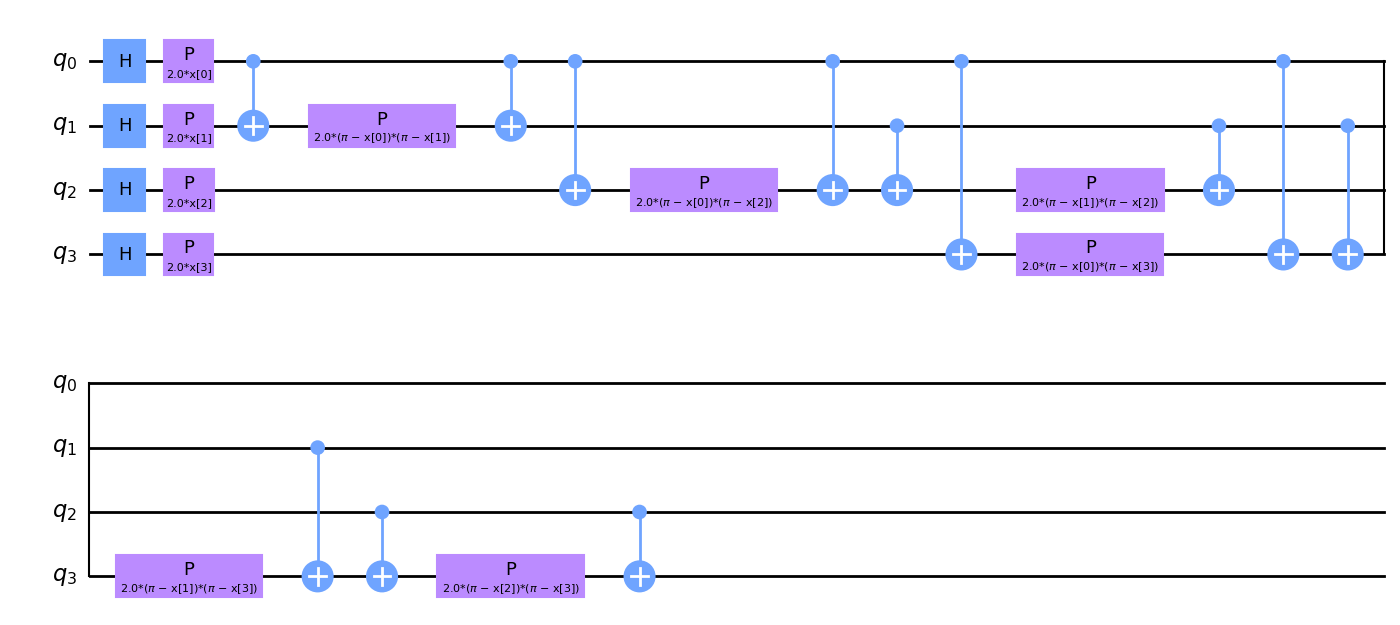

In [6]:
num_features = X_train.shape[1]

zz_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
zz_feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

#### Create Sampler and Optimizer 

In [7]:
sampler = Sampler()

optimizer_c = COBYLA(maxiter=100) 

In [8]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
vqc = VQC(
    sampler = sampler,
    feature_map = zz_feature_map,
    ansatz = EfficientSU2(num_qubits=num_features, reps=1),
    optimizer = optimizer_c,
    callback = callback_graph
)

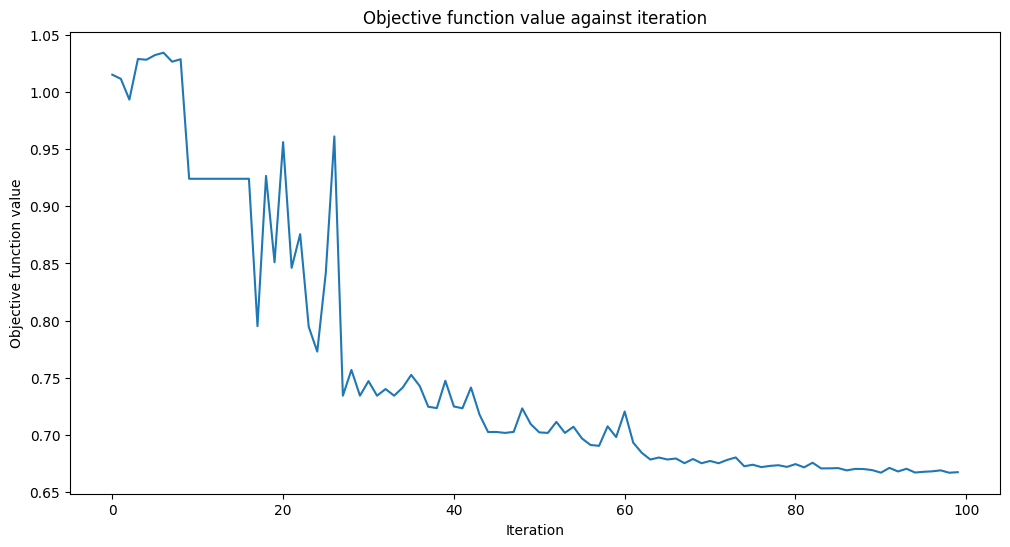

Training time: 1741 seconds


In [10]:
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train.values.reshape(-1, 1))
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [12]:
# save the vqc model - RUN THISSS 
vqc.save("vqc_model_1")

#### Get Accuracy - todo

In [5]:
# load the vqc model
vqc = VQC.load("vqc_model_1")

In [9]:
from sklearn.metrics import accuracy_score

y_pred = vqc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Prediction accuracy: {accuracy}")

Prediction accuracy: 0.845


In [10]:
# show length of y_pred
print(len(y_pred))

200


In [11]:
# show length of X_test
print(len(X_test))

200


In [14]:
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

# add the actual labels back to the X_test dataframe
X_test['target'] = y_test

test_dataset = StandardDataset(X_test, 
                          label_name='target', 
                          protected_attribute_names=['gender'],
                          favorable_classes=[1],
                          privileged_classes=[[1]]
                          )

# Add the labels back to the X_train dataframe
X_train['target'] = y_train

train_dataset = StandardDataset(X_train,
                            label_name='target', 
                            protected_attribute_names=['gender'],
                            favorable_classes=[1],
                            privileged_classes=[[1]]
                            )

In [15]:
# copy of dataset_all
test_data_predicted = test_dataset.copy()
test_data_predicted.labels = y_pred.reshape(-1, 1)

In [16]:
# Classification metrics 
metric_prediction = ClassificationMetric(test_dataset, 
test_data_predicted, 
unprivileged_groups=unprivileged_groups, 
privileged_groups=privileged_groups)

In [17]:
# get the shape of metric_prediction
print(metric_prediction)

In [19]:
# compute the fairness of metric prediction
print("The consistency is:", metric_prediction.consistency()) 

# compute the fairness of metric prediction
print("The disparate impact is:", metric_prediction.disparate_impact())

# compute the fairness of metric prediction
print("The equal opportunity difference is:", metric_prediction.equal_opportunity_difference())

# compute the fairness of metric prediction
print("The average odds difference is:", metric_prediction.average_odds_difference()) # This is NAN?? 

# compute the fairness of metric prediction
print("The statistical parity difference is:", metric_prediction.statistical_parity_difference())

The consistency is: [0.683]
The disparate impact is: 0.0
The equal opportunity difference is: -0.6808510638297872
The average odds difference is: nan
The statistical parity difference is: -0.6808510638297872
